#Routing Optimization of Capable Vehicles Using the Ant Colony Algorithm

The Vehicle Routing Problem (VRP) is an optimization challenge in logistics in which it is necessary to determine the most efficient route for a set of vehicles, in order to serve a set of customers, respecting the load capacity of each vehicle. The objective is to minimize the total cost, considering the distance traveled and the number of vehicles used. It is an important problem in delivery and distribution operations.

## Imports e funções auxiliares.

In [ ]:
!pip install tqdm

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import math
import numpy as np
from tqdm import tqdm

def distance(coords1, coords2):
    lat1, lon1 = coords1
    lat2, lon2 = coords2

    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(lat2)
    lon2_rad = math.radians(lon2)

    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = math.sin(dlat/2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    R = 6371  # Earth's radius in kilometers
    distance = R * c
    return distance

def read_graph_from_file(file_path):
    df = pd.read_csv(file_path, delimiter='\t')

    G = nx.Graph()

    for index, row in df.iterrows():
        city_name = row['nome']
        latitude = float(row['latitude'].replace(',', '.'))
        longitude = float(row['longitude'].replace(',', '.'))
        G.add_node(city_name, latitude=latitude, longitude=longitude)
    for city1 in G.nodes():
        for city2 in G.nodes():
            if city1 != city2:
                lat1, lon1 = G.nodes[city1]['latitude'], G.nodes[city1]['longitude']
                lat2, lon2 = G.nodes[city2]['latitude'], G.nodes[city2]['longitude']
                distance = geodesic((lat1, lon1), (lat2, lon2)).kilometers
                G.add_edge(city1, city2, distance=distance)
    return G

def graph_to_dict(G):
    cidades = {}
    for city in G.nodes():
        latitude, longitude = G.nodes[city]['latitude'], G.nodes[city]['longitude']
        cidades[city] = (latitude, longitude)
    return cidades

def update_graph_with_demands(G, customer_demands):
    for customer, demand in customer_demands.items():
        G.nodes[customer]['demand'] = demand
    return G

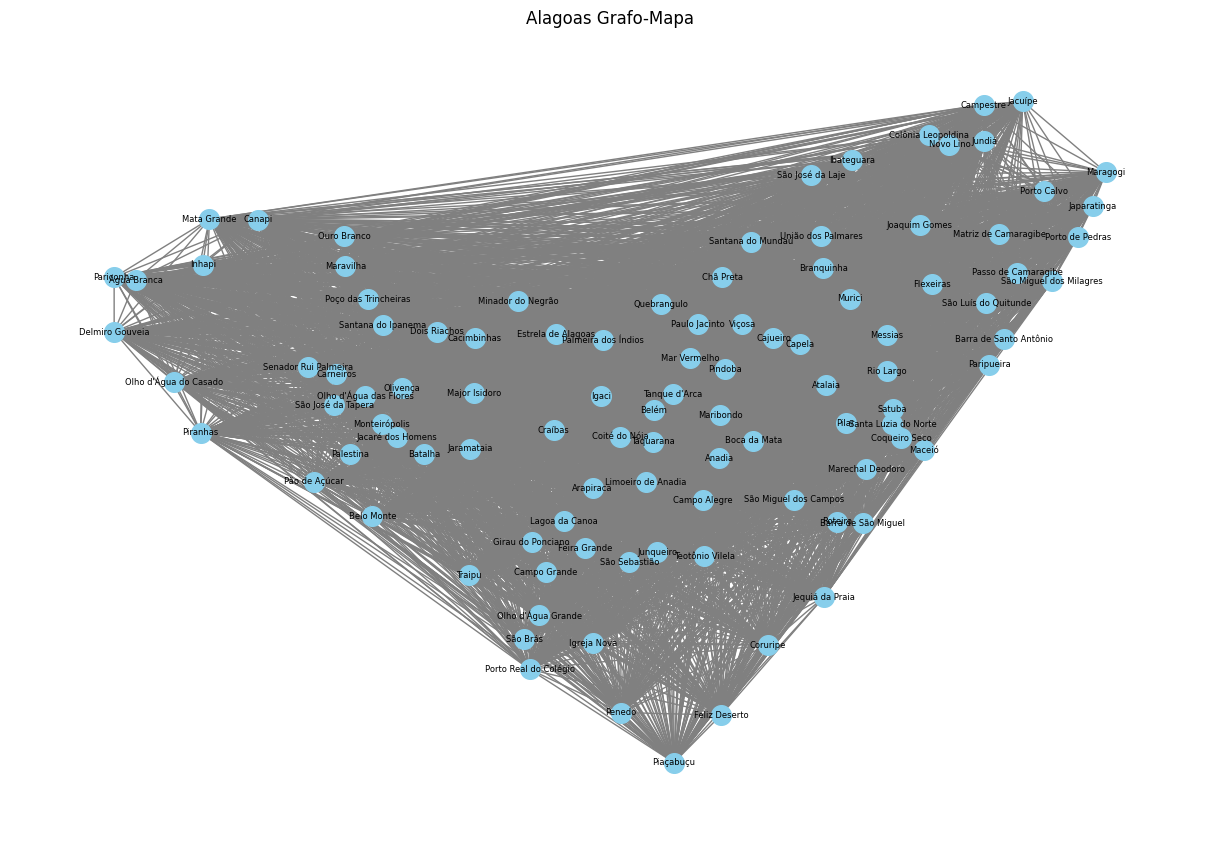

In [ ]:
file_path = '/content/alagoas_TSP.txt'
alagoas = read_graph_from_file(file_path)
pos = {city: (alagoas.nodes[city]['longitude'], alagoas.nodes[city]['latitude']) for city in alagoas.nodes()}
plt.figure(figsize=(12, 8))
nx.draw(alagoas, pos, with_labels=True, node_size=200, font_size=6, node_color='skyblue', edge_color='gray')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'distance'), font_size=8)

plt.title('Alagoas Grafo-Mapa')
plt.show()

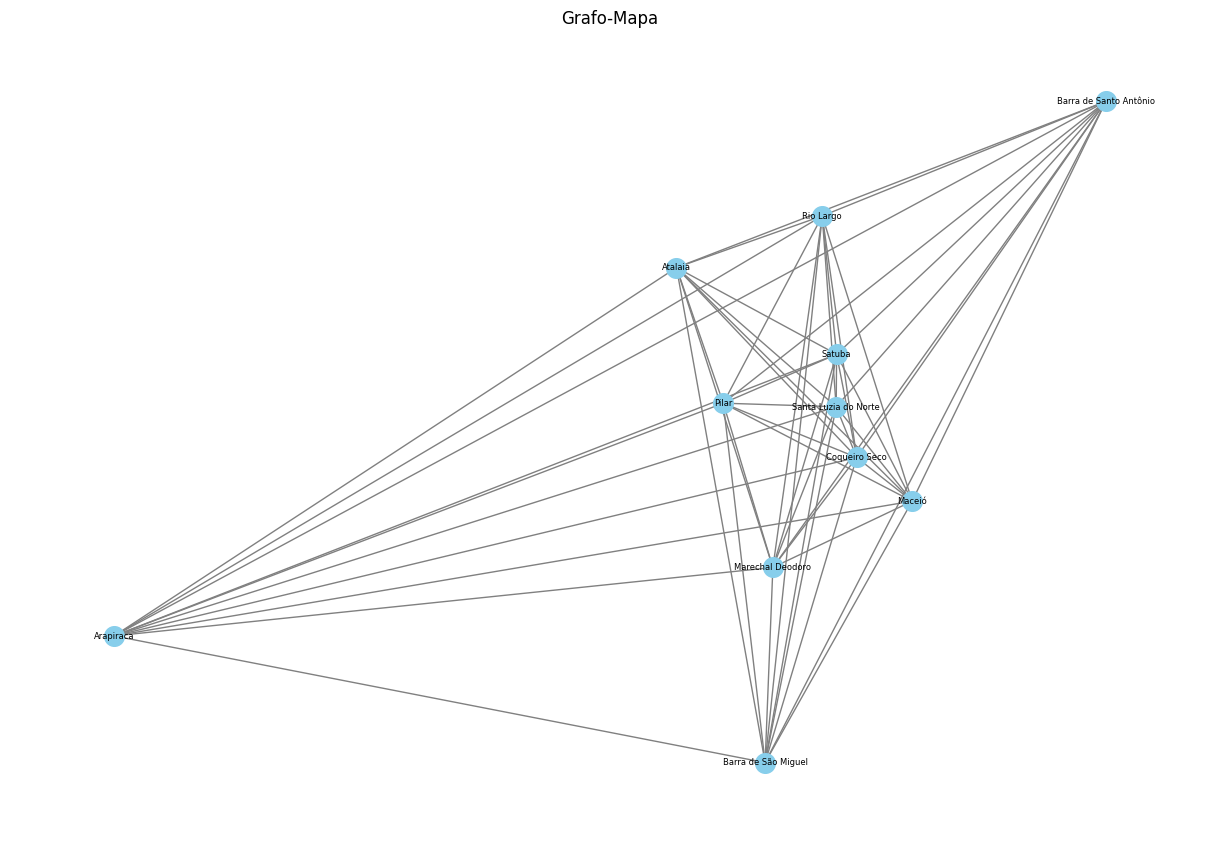

In [ ]:
# file_path = '/content/alagoas_TSP.txt'
file_path = 'metropole.txt'
G = read_graph_from_file(file_path)
pos = {city: (G.nodes[city]['longitude'], G.nodes[city]['latitude']) for city in G.nodes()}
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=200, font_size=6, node_color='skyblue', edge_color='gray')
# nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'distance'), font_size=8)

plt.title('Grafo-Mapa')
plt.show()

## Equations in the ACO Algorithm for CVRP

1. Probability of Selecting the Next City (Next Destination Choice)
The probability of an ant selecting the next city (destination) depends on two main components: the pheromone trail (pheromone) and the distance between cities. The general formula for calculating this probability is as follows:

$p_{ij} = \frac{{\tau_{ij}^\alpha \cdot \eta_{ij}^\beta}}{{\sum_{k \in \text{unvisited_cities}} \tau_{ik}^\alpha \cdot \eta_{ik}^\beta}}$

Where:
* $p_{ij}$ is the probability of the ant moving from city $i$ to city $j$.
* $\tau_{ij}$ is the amount of pheromone on the edge between cities $i$ and $j$.
* $\eta_{ij}$ is a function describing the influence of the distance between cities $i$ and $j$ (typically $\eta_{ij}=\frac{1}{{\text{distance between }i \text{ and }j}}$).
* $\alpha$ and $\beta$ are parameters that control the relative weight of pheromone trail and distance, respectively.



2. Pheromone Update
The amount of pheromone on an edge is updated after each ant completes its path. The formula for updating is as follows:

$\tau_{ij} \leftarrow (1 - \rho) \cdot \tau_{ij} + \Delta\tau_{ij}\$

Where:
* $\rho$ is the rate of pheromone evaporation.
* $\Delta\tau_{ij}$ is the amount of pheromone deposited on the edge between cities $i$ and $j$ by all ants.

3. Pheromone Deposit by Ants
After each ant completes its path, an amount of pheromone is deposited on the trail as follows:

$\Delta\tau_{ij} = \frac{Q}{\text{path length}}$

Where:

* $\Delta\tau_{ij}$ is the amount of pheromone deposited on the edge between cities $i$ and $j$ by the current ant.
* $Q$ is a constant representing the amount of pheromone to be deposited by each ant.
* The $\text{path length}$ is the total distance traveled by the ant along the path.

## Ant Colony

In [ ]:
def ant_colony_cvrp(graph, n_ants, n_iterations, alpha, beta, evaporation_rate, Q, vehicle_capacity, start_city=None):
    """
    Resolve o Problema do Caixeiro Viajante com Restrições de Capacidade (CVRP) usando um algoritmo de Colônia de Formigas.

    Parâmetros:
    graph (networkx.Graph): O grafo representando as cidades e suas distâncias.
    n_ants (int): O número de formigas que percorrerão o grafo.
    n_iterations (int): O número de iterações do algoritmo ACO.
    alpha (float): Peso da trilha de feromônio na escolha da próxima cidade.
    beta (float): Peso da distância na escolha da próxima cidade.
    evaporation_rate (float): Taxa de evaporação do feromônio existente no grafo.
    Q (float): Quantidade de feromônio a ser depositada pelas formigas.
    vehicle_capacity (float): Capacidade máxima do veículo.
    start_city (str, opcional): A cidade de início para todas as formigas. Se não for especificada, será escolhida aleatoriamente.

    Retorna:
    tuple: Uma tupla contendo o melhor caminho encontrado (lista de cidades) e o comprimento desse caminho.
    """
    cities = list(graph.nodes()) #Lista de cidades no grafo
    n_cities = len(cities) #Quantidade total de cidades
    city_indices = {city: i for i, city in enumerate(cities)}  #atribui indices a todas as cidades
    pheromone = np.ones((n_cities, n_cities)) #inicia feromonio
    best_path = None #melhor caminho nenhum
    best_path_length = np.inf  #melhor caminho infinito
    demands = nx.get_node_attributes(graph, "demand")  #pega todas as demandas de entregas
    cities_with_demands = [city for city in demands if demands[city] > 0 and city != start_city] #lista todas as cidades com demandas
    demands_indices = {city: i for i, city in enumerate(cities_with_demands)} #atribui indices a todas as cidades com demandas


    for iteration in tqdm(range(n_iterations), desc='ACO Iteration'):
    # for iteration in range(n_iterations): #iterações
        paths = []                   #lista de caminhos
        path_lengths = []             #lista de comprimentos

        for ant in range(n_ants):       #caminho de uma formiga
            demands_list = [demands[city] for city in cities_with_demands] #lista de demandas de cada cidade, a cidade é a posição da lista.
            visited = [False] * len(cities_with_demands)    #lista de cidades visitadas da lista de cidades com demandas
            if start_city is None:          #se não tiver cidade inicial (SEMPRE TEM QUE TER!)
                current_city = np.random.choice(cities)  #escolhe aleatrimanente uma cidade
            else:
                current_city = start_city  #começa da cidade especificada (É O GALPÃO)

            path = [current_city]   #lista no caminho
            path_length = 0         #inicia a contagem 0km
            ant_capacity = vehicle_capacity  # inicia a capacidade da formiga

            while False in visited:       #Enquanto houver cidade não visitada
                unvisited_cities = [city for city in cities_with_demands if not visited[demands_indices[city]]]   #lista as cidades não visitadas
                probabilities = np.zeros(len(unvisited_cities))    #probabilidades
                j = city_indices[current_city] #indice da cidade atual

                if min(nx.get_node_attributes(graph, "demand")[city] for city in unvisited_cities) > ant_capacity: #ATENÇÃO: se a capacidade da formiga no momento da entrega for menor do que a menor demanda, ela volta para o deposito para reabastecer
                    # print('aqui')
                    next_city = start_city  # Forçar a formiga a retornar ao start_city
                    path_length += graph[current_city][next_city]["distance"] #adiciona a distancia do caminho para o deposito
                    path.append(next_city)  #lista no caminho
                    ant_capacity = vehicle_capacity #pega mais carga
                    next_city = np.random.choice(unvisited_cities) #Ao voltar no deposito, a proxima cidade é aleatória
                else:
                    #O bloco abaixo calcula a probabilidade de escolha da proxima cidade
                    for i, unvisited_city in enumerate(unvisited_cities):
                        k = city_indices[unvisited_city] #indice da cidade não visitada
                        numerator = (pheromone[j][k] ** alpha) * ((1.0 / graph[current_city][unvisited_city]["distance"]) ** beta)
                        denominator = 0.0
                        for city_i in unvisited_cities:
                            k_i = city_indices[city_i]
                            denominator += (pheromone[j][k_i] ** alpha) * ((1.0/graph[current_city][city_i]["distance"]) ** beta)
                        probabilities[i] = numerator / denominator
                    probabilities /= np.sum(probabilities)
                    next_city = np.random.choice(unvisited_cities, p=probabilities)

                #A cidade com melhor probabilidade foi escolhida (ou acabou de sair do galpão) e listada no historico de caminhos
                path.append(next_city)
                path_length += graph[current_city][next_city]["distance"] #distancia incrementada
                visited[demands_indices[next_city]] = True     #cidade visitada marcada como visitada
                current_city = next_city  #proxima cidade

                if current_city != start_city: #se a cidade alcançada não for o deposito
                    demand = demands_list[demands_indices[current_city]]
                    ant_capacity -= demand   #a formiga faz a entrega
                    demands_list[demands_indices[current_city]] = 0


            paths.append(path)  #lista o caminho de uma formiga X na lista de caminhos das formigas
            path_lengths.append(path_length) #lista a distancia percorrida pela formiga X

            # print(path_length, best_path_length)
            if path_length < best_path_length: #se a distancia for menor que a melhor distancia
                #atualiza
                best_path = path
                best_path_length = path_length

        pheromone *= (1 - evaporation_rate) #feronomio depositado no caminho evapora (uma parte)
        #O bloco de código a seguir atualiza o feronomio das arestas do grafo de caminho.
        for path, path_length in zip(paths, path_lengths):
            for i in range(n_cities - 1):
                j = city_indices[path[i]]
                k = city_indices[path[i + 1]]
                # k = city_indices[path[(i + 1) % len(path)]]
                pheromone[j][k] += Q / path_length
            j = city_indices[path[-1]]
            k = city_indices[path[0]]
            pheromone[j][k] += Q / path_length

    return best_path, best_path_length

In [ ]:
n_ants = 600
n_iterations = 300
alpha = 1.5
beta = 2.0
evaporation_rate = 0.2
Q = 1.0
vehicle_capacity = 50

# Cada valor representa a demanda de uma cidade, imagine como sendo o volume, ou peso de uma encomenda.
# Não incluir a cidade de origem
customer_demands = {
    'Satuba': 10,
    'Rio Largo': 10,
    'Coqueiro Seco': 10,
    'Santa Luzia do Norte': 10,
    'Pilar': 10,
    'Marechal Deodoro': 10,
    'Arapiraca': 10,
    'Atalaia': 10,
    'Barra de Santo Antônio': 10,
    'Barra de São Miguel': 10
    # Add demands for other cities as needed
}

G = update_graph_with_demands(G, customer_demands)
answer, distance = ant_colony_cvrp(G, n_ants, n_iterations, alpha, beta, evaporation_rate, Q, vehicle_capacity, 'Maceió')

ACO Iteration: 100%|██████████| 300/300 [04:08<00:00,  1.21it/s]


In [ ]:
print(distance)
for city in answer:
  print(city)

242.74102545051375
Maceió
Barra de Santo Antônio
Rio Largo
Satuba
Santa Luzia do Norte
Coqueiro Seco
Maceió
Barra de São Miguel
Marechal Deodoro
Pilar
Atalaia
Arapiraca


## Funções para criar figura final.

In [ ]:
import imageio
import os

# directory to store the frames (images) of each step
output_dir = 'frames/'
os.makedirs(output_dir, exist_ok=True)

# Draw the graph with geographic positions as node positions (similar to previous code)
pos = {city: (G.nodes[city]['longitude'], G.nodes[city]['latitude']) for city in G.nodes()}

# Add a new edge attribute to indicate whether an edge is part of the path
for city1, city2 in zip(answer, answer[1:]):
    G.edges[city1, city2]['path_edge'] = True

# Create frames and save them as images
frames = []
for step, city in enumerate(answer, start=1):
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=200, font_size=6, node_color='skyblue', edge_color='gray')

    # Highlight the current city in red
    nx.draw_networkx_nodes(G, pos, nodelist=[city], node_color='red', node_size=200)

    # Highlight the edges that are part of the path
    if step > 1:
        for prev_city, next_city in zip(answer[:step-1], answer[1:step]):
            if G.has_edge(prev_city, next_city) and G.edges[prev_city, next_city].get('path_edge', False):
                nx.draw_networkx_edges(G, pos, edgelist=[(prev_city, next_city)], edge_color='red', width=3)

    plt.title(f'Step {step}: Visiting {city}')
    plt.savefig(f'{output_dir}frame_{step:03d}.png')
    plt.close()

# Convert frames to a gif
images = []
for step in range(1, len(answer) + 1):
    image_path = f'{output_dir}frame_{step:03d}.png'
    images.append(imageio.imread(image_path))

gif_output_path = 'path_traversal.gif'
imageio.mimsave(gif_output_path, images, duration=1, loop=10000)  # Duration in seconds per frame

print(f'Gif saved: {gif_output_path}')


<ipython-input-13-5514d2cea5df>:38: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_path))


Gif saved: path_traversal.gif


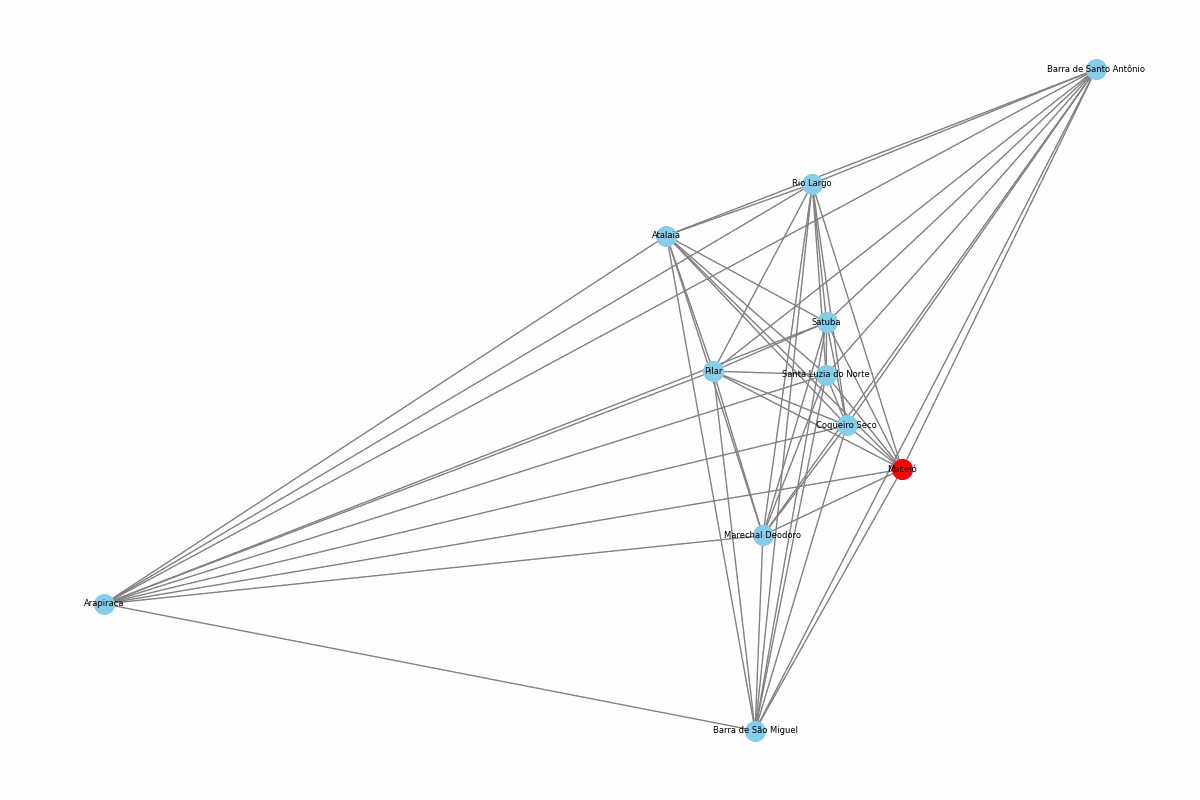

In [ ]:
from IPython.display import Image
Image(open('path_traversal.gif','rb').read()) #Easy way